In [84]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import precision_recall_fscore_support
import random
import matplotlib.pyplot as plt
import itertools
import seaborn as sns

# k-nearest neighbors

This dataset was obtained from https://archive.ics.uci.edu/ml/datasets/Heart+Disease (this is a great resource for datasets to try machine learning on). It has data on patients that are and are not diagnosed with heart disease.

The attributes are:
* age: age in years 
* sex: sex (1 = male; 0 = female) 
* cp: chest pain type 
 * -- Value 1: typical angina 
 * -- Value 2: atypical angina 
 * -- Value 3: non-anginal pain 
 * -- Value 4: asymptomatic 
* trestbps: resting blood pressure (in mm Hg on admission to the hospital) 
* chol: serum cholestoral in mg/dl 
* fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false) 
* restecg: resting electrocardiographic results 
 * -- Value 0: normal 
 * -- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV) 
 * -- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria 
* thalach: maximum heart rate achieved 
* exang: exercise induced angina (1 = yes; 0 = no) 
* oldpeak = ST depression induced by exercise relative to rest 
* slope: the slope of the peak exercise ST segment 
 * -- Value 1: upsloping 
 * -- Value 2: flat 
 * -- Value 3: downsloping 
* ca: number of major vessels (0-3) colored by flourosopy 
* thal: 3 = normal; 6 = fixed defect; 7 = reversable defect 
* num: diagnosis of heart disease (angiographic disease status) 
 * -- Value 0: absence.
 * -- Value 1,2,3,4: presence of heart disease


# Explore the data

Read in the data, modify the dependent variable name and plot a histogram of the ages of patients, both healthy and those with heart disease.

In [85]:
df = pd.read_csv('cleveland.csv')

# Collapse all values 1-4 into a single value so that "num" is boolean
df = df.rename({'num':'disease'}, axis=1)
df['disease'] = df.disease.apply(lambda x: min(x, 1))
df.drop(df[df['thal'] == '?'].index, inplace=True)
display(df.head(5))

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,disease
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


# multiple dimensions


In [86]:
def knnPredict(data, attributes, numOfNeighbors, target='disease'):
    nn = NearestNeighbors(n_neighbors=numOfNeighbors, metric='euclidean', algorithm='auto')
    
    # Standardize
    newAttributes = []
    for attribute in attributes:
        standard = data[attribute]-data[attribute].mean()/data[attribute].std()
        standard.name = standard.name+'_s'
        newAttributes.append(standard.name)
        data = pd.concat([data,standard],axis=1)
        
    # Build underlying structure with standardized data   
    X = data[newAttributes].values
    y = data[target].values
    fit = nn.fit(X)
    
    # Choose a random patient
    i = random.randint(0,len(X)-1)
    patientX = X[i]
    patienty = y[i]
    # display('Our patient',data.iloc[i])
    
    # Find the k nearest neighbors, not including self
    distances, indices = fit.kneighbors([patientX],numOfNeighbors+1)
    nbrs = data.iloc[indices[0]]
    # Delete self from data
    nbrs = nbrs.drop(data.iloc[i].name)
    # display(nbrs)
    
    # Count the number of neighbors that have target
    have = nbrs[nbrs[target] == 0].count()[target]
    # Count the number of neighbors that DON'T have target
    dontHave = nbrs[nbrs[target] == 1].count()[target]
    # print('Have: {}\ndontHave: {}'.format(have, dontHave))
    
    # Predict that our random patient is like the majority of its neighbors
    predict = 0 if (dontHave > have) else 1
    # According to the records, did our patient have the target
    actual = 0 if (patienty == 0) else 1
    success = predict == actual
    # print('Sucess:',success)
    return success, patienty == 0

In [87]:
def testMeSenpai(data, attributes, numOfNeighbors, numOfTests=1, target='disease'):
    y_pred = []
    y_true = []
    for test in range(numOfTests):
        yPred, yAct = knnPredict(data, attributes, numOfNeighbors)
        y_pred.append(yPred)
        y_true.append(yAct)
    return y_pred ,y_true

In [88]:
def crossValidate(data, attributes, numOfNeighbors, numOfTests, target='disease', level = 10):
    folds = []
    for i in range(level):
        folds.append(data.sample(frac = 1/level))
        
    # Train missing one fold
    for i in range(level-1):
        temp = pd.concat([data,folds[i]])
        temp = temp.drop_duplicates(keep=False)
        
        y_pred,y_true = testMeSenpai(temp, attributes, numOfNeighbors, numOfTests, target='disease')
        (p,r,f,s) = precision_recall_fscore_support(y_pred,y_true,zero_division=0)
        print(p,r,f,s,'\n')
        
df1 = df.copy()
k = 5
numOfTests = 5
attributes = ['age','trestbps']

crossValidate(df1,attributes,k,numOfTests)
# y_pred, y_true = testMeSenpai(df1,attributes,k,numOfTests)
# (p,r,f,s) = precision_recall_fscore_support(y_pred,y_true)
# display(p,r,f,s)

[0.66666667 0.        ] [0.5 0. ] [0.57142857 0.        ] [4 1] 

[0.5        0.33333333] [0.33333333 0.5       ] [0.4 0.4] [3 2] 

[0.5        0.33333333] [0.33333333 0.5       ] [0.4 0.4] [3 2] 

[0.5 0. ] [0.25 0.  ] [0.33333333 0.        ] [4 1] 

[0.5        0.33333333] [0.33333333 0.5       ] [0.4 0.4] [3 2] 

[0.5        0.33333333] [0.33333333 0.5       ] [0.4 0.4] [3 2] 

[1. 0.] [0.4 0. ] [0.57142857 0.        ] [5 0] 

[1.   0.25] [0.25 1.  ] [0.4 0.4] [4 1] 

[0. 0.] [0. 0.] [0. 0.] [1. 4.] 



In [89]:
def testAgainstTest(testData,attributes,k):
    y_pred, y_true = testMeSenpai(testData,attributes,k)
    (p,r,f,s) = precision_recall_fscore_support(y_pred,y_true)
    return p,r,f,s

The model is the value of k (nearest neigbors) and set of attributes

## The challenge

In [90]:
# Day of the challenge set, all we need to do is change this file name and run it
new_df = pd.read_csv('cleveland-test-sample.csv')

# Collapse all values 1-4 into a single value so that "num" is boolean
new_df = new_df.rename({'num':'disease','Unnamed: 0':'id'}, axis=1)
new_df['disease'] = new_df.disease.apply(lambda x: min(x, 1))

# Build a bigger data set to 
temp = pd.concat([df,new_df]).reset_index()


## chosen features

In [91]:


chosen_features = ['cp', 'trestbps', 'chol', 'restecg', 'thalach', 'exang', 'thal', 'age']
attributes = ['age','trestbps','chol', 'thalach']
# standardizing noncatagorical data
data1 = df.copy()
for attribute in attributes:
    standard = (data1[attribute]-data1[attribute].mean())/data1[attribute].std()
    chosen_features.remove(standard.name)
    chosen_features.append(standard.name+'_s')
    standard.name = standard.name+'_s'
    data1 = pd.concat([data1,standard],axis=1)
    data1.drop(attribute,axis=1,inplace=True)
def makefeaturesList(chosen_features, n):
    featureslist = list(itertools.combinations(chosen_features,n)) #
    featureslist = [list(x) for x in featureslist]
    return featureslist
# data 1 is processed

## monte carlo data split with selected features

In [92]:
# make random split for one monte carlo cross validation run
def monteCarloCVSplit(data : pd.DataFrame , level = 10):
    CVtest = data.sample(frac = 1/level)
    CVtrain = data.drop(CVtest.index)
    return CVtrain, CVtest

### run knn on given attributes and CV split

In [93]:
def knnPredictions(CVtrain, CVTest, attributes, k, target='disease'):
    nn = NearestNeighbors(n_neighbors=k , metric='euclidean', algorithm='auto')
    
    # Build underlying structure with standardized data   
    X = CVtrain[attributes].values
    y = CVtrain[target].values
    
    testX = CVTest[attributes].values
    testy = CVTest[target].values
    fit = nn.fit(X) # fits training data to model
    
    # nbrs = neighbors
    #this fit finds the nearest neigbors from the training set to the test set 
    distances, nbrs = fit.kneighbors(testX, n_neighbors = k) 
    
    # Count the number of neighbors that have target

    diseasdedNbrCount = []
    for nbrList in nbrs:
        diseasdedNbrCount.append([1 if y[nbr] == 1 else 0 for nbr in nbrList])
    
    predictions = []
    for l in diseasdedNbrCount:
        numOfDiseased = sum(l)
        if numOfDiseased > k/2:
            predictions.append(1)
        else:
            predictions.append(0)
    # print(predictions,'\n',diseasdedNbrCount)
    return predictions , testy
    

In [94]:
# make combinations of up to 8 attriubutes
def getBestknn(data, chosen_features, numOfNeighbors = 7):
    bestModel= [0,[]]
    for i in range(8):
        featuresList = makefeaturesList(chosen_features,i+1)
        # for each combination of size i
        for j in range(len(featuresList)):
            # Do monte carlo validation 10 times
            pSum = 0
            rSum = 0
            f1Sum = 0
            for k in range(10):
                CVtrain1, CVtest1 = monteCarloCVSplit(data)
                #train model and report scores    
                preds, actuals = knnPredictions(CVtrain1, CVtest1, featuresList[j] , numOfNeighbors)
                (p,r,f,s) = precision_recall_fscore_support(preds,actuals,zero_division=0,average='binary')
                if not p == 0 and not r == 0:
                    f1 = 2 * ((p*r)/(p + r))
                else:
                    f1= 0
                pSum += p
                rSum += r
                f1Sum += f1
            avgP = pSum/10
            avgR = rSum/10
            avgF1 = f1Sum/10
            # Update our best model
            if avgF1 > bestModel[0]:
                bestModel = [avgF1,featuresList[j],avgP,avgR]
    return bestModel

In [104]:
bestmodel = getBestknn(data1,chosen_features)
print(bestmodel)

[0.8126130429188958, ['cp', 'thal', 'trestbps_s', 'chol_s', 'thalach_s'], 0.8158277103013946, 0.825071790954144]


make changes

In [96]:
power = pd.read_csv('city_power_consumption.csv')
power = power.rename(columns={'Zone 1 Power Consumption':'Zone_1_Power'})
powerMean = power['Zone_1_Power'].mean()
power['highPowerUse'] = power.Zone_1_Power>powerMean
# power.plot(power['Temperature'])
# sns.lineplot(data = power, x = 'Temperature')

In [97]:
attributes = ['Temperature','Humidity','Wind Speed','Zone 2  Power Consumption']
k = 50
target = 'highPowerUse'
# display(power)
# display(renameMe(power,attributes,k,target = target))
# display(testMeSenpai(power,attributes,k,numOfTests = 10,target = target))
# crossValidate(power,attributes,k,numOfTests,target=target)

<AxesSubplot:xlabel='Temperature', ylabel='Zone_1_Power'>

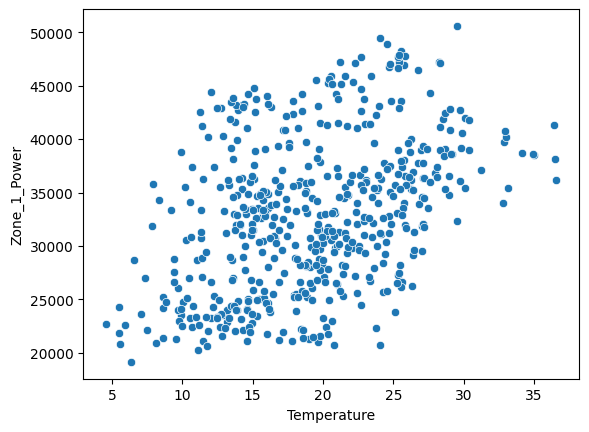

In [98]:
sns.scatterplot(data = power.sample(frac=.01), x = 'Temperature', y = 'Zone_1_Power')

<AxesSubplot:xlabel='Humidity', ylabel='Zone_1_Power'>

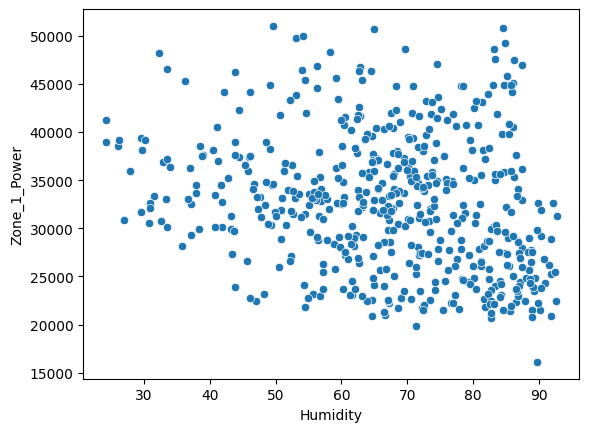

In [99]:
sns.scatterplot(data = power.sample(frac=.01), x = 'Humidity', y = 'Zone_1_Power')

# Challenge set

In [102]:
# Day of the challenge set, all we need to do is change this file name and run it
new_df = pd.read_csv('cleveland-test-sample.csv')


# Collapse all values 1-4 into a single value so that "num" is boolean
new_df = new_df.rename({'num':'disease','Unnamed: 0':'id'}, axis=1)
new_df['disease'] = new_df.disease.apply(lambda x: min(x, 1))

chosen_features = ['cp', 'trestbps', 'chol', 'restecg', 'thalach', 'exang', 'thal', 'age']
attributes = ['age','trestbps','chol', 'thalach']
# standardizing noncatagorical data

for attribute in attributes:
    standard = (new_df[attribute]-new_df[attribute].mean())/new_df[attribute].std()
    chosen_features.remove(standard.name)
    chosen_features.append(standard.name+'_s')
    standard.name = standard.name+'_s'
    new_df = pd.concat([new_df,standard],axis=1)
    new_df.drop(attribute,axis=1,inplace=True)

bestmodel = getBestknn(new_df,chosen_features)
print(bestmodel)

# # Build a bigger data set to 
# temp = pd.concat([df,new_df]).reset_index()

[0.9600000000000002, ['cp', 'exang', 'thal', 'trestbps_s', 'chol_s'], 0.9666666666666666, 0.9666666666666666]
